In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import gymnasium as gym
import random
import math
import matplotlib.pyplot as plt

In [3]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode='human')
env_1 = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)

# The agent starts at position [0,0].
# The agent must reach the goal location.
# To make our environment harder, the surface is slippery --> start with non-slippery surface.

# As we have a 4x4 map, we have 16 possible states.
# We have 4 distinct actions at every states, up, down, left and right.
# Each state is represented with an integer ranging from 0 to 15.
    # 0 to 3 from left to right in a single row.
    
# Reward is 0 for every state, except the state with goal which is 1.

In [12]:
env_2 = gym.make("CliffWalking-v0", render_mode='human')
env_3 = gym.make("CliffWalking-v0")

# Player starts at [3,0] of the 4x12 grid, goal located at [3,11].
# Cliff runs along [3, 1...10]. Returns to start location.
# Same 4 movements as with Frozen Lake.
# Cliff has penalty.
# Penalty of -1 for every step taken, which should enable the agent to take the shortest route to maximize the reward.
# No reward when reaching goal, so we are trying to minimize the penalty.

In [5]:

class Agent():
    '''
        Agent class which contains algorithms for the agent to explore and learn from an environment.
    '''
    
    def __init__(self, envi: gym.Env):
        self.num_s = envi.observation_space.n
        self.num_a = envi.action_space.n
        self.transition = envi.unwrapped.P
        self.env = envi

        self.q_table = np.zeros((self.num_s, self.num_a))
        self.v_table = np.zeros(self.num_s)

        # Arbitrary initialization of the deterministic policy.
        self.policy = np.zeros(self.num_s).astype(int)
        
        self.ez_duration = 0 # For ez_greedy.
        self.ez_action = 0 # For ez_greedy.

    def reset_policy(self):
        '''
            Resets policy.
        '''
        self.policy = np.zeros(self.num_s).astype(int)

    def use_policy(self, env: gym.Env, max_no_steps: int=15):
        '''
            The agent test the policy within an environment.
            Args:
                env: Environment in which the agent will interact.
                max_no_steps: The maximum number of steps allowed within the environment.
                    Removes the problem of infinite loop with non-termination policies.
        '''
        
        state, _ = env.reset()
        action = self.policy[state]
        
        reward = 0
        counter = 0 # If policy not good, then this will stop
    
        while(True):
            next_state, r, done, goal, _ = env.step(action)
            reward += r
            if done: break
                
            action = self.policy[state]
            state = next_state
            
            counter += 1
            if counter >= max_no_steps: break
                
        return reward
#============================================================================================        
# Value Iteration algorithm.

    def value_iteration(self, discount_rate=0.9, theta=0.05):
        '''
            No exploration algorithm is needed.
            Algorithm stops when the residual over one iteration if below hyper-parameter theta.
        '''
        
        while True:
            delta = 0 # Max change over one iteration.
            
            # For each state, calculate the max value possible.
            for s in range(self.num_s):
                
                v = self.v_table[s]
                
                # To be more efficient with numpy, should not append but should allocate to 
                # an already existing ndarray.
                i = np.zeros(self.num_a) # More efficient.

                # Calculate state-action value for each action.
                for a in range(self.num_a):
                    temp = self.action_state(discount_rate, s, a)
                    i[a] = temp
                self.v_table[s] = np.max(i)
                
                delta = max(delta, abs(v - self.v_table[s]))
            if delta < theta: break
                
        # Now that each state-value has converged to V*,
        # we can create the optimal policy out of it.
        pi = np.zeros(self.num_s, dtype=int)
        for s in range(self.num_s):
            i = np.zeros(self.num_a) # More efficient.
            
            # Action a E A that maximizes the state value.
            for a in range(self.num_a):
                temp = self.action_state(discount_rate, s, a)
                i[a] = temp
            self.policy[s] = np.argmax(i)


    # For action a, calculates its current expected value at state s.
    def action_state(self, discount_rate, s, a):
        '''
            For action a, calculates its current expected value at state s.
        '''
        
        value  = 0 # Inital value of 0.

        for p, s_, r, _ in self.transtion[s][a]:
            value += p * (r + discount_rate * self.v_table[s_])
        return value
    
#=========================================================================
# Exploration algorithms.

    def decay(self, time: int, N_0=1, decay_rate=0.003):
        '''
            To be used with epsilon. Negative exponential function, which decreases epsilon over time.
            Value returned should be used with a copy of the original epsilon.
            Args:
                time: Time t.
                N_0: Value of epsilon at time t=0.
                decay_rate: Higher rate leads to a lower epsilon over time.
        '''
        
        epsilon = N_0 * (math.e ** (-decay_rate * time))
        return epsilon

    def e_greedy(self, epsilon: float, s: int):
        '''
            First exploration algorithm.
            Returns with epsilon rate if agent will explore, rather than exploit the environment.

            Args:
                epsilon: Rate of exploration.
                s: State at which an action must be taken.
        '''
        
        if random.random()  < epsilon:
            return random.randrange(self.num_a)
        else:
            return np.argmax(self.q_table[s])

    def boltzmann(self, s: int, temp: float):
        '''
            Second exploration algorithm.
            Softmax function with hyper-parameter denoted temperature.
            Cooling the temperature decreases the entropy, accentuating the common events.

            Args:
                s: State at which an action must be taken.
                temp-> 0: Uniform distribution.
                temp-> Infinity: Trivial distribution with all mass concentrated on highest-prob class.
        '''
        
        actions = np.arange(0, self.num_a)
        b = nn.Softmax(dim=0)
        q_row = torch.from_numpy(self.q_table[s]) # Conversion needed with nn.Softmax().

        result = b(q_row/temp).numpy()

        return int(np.random.choice(actions, p=result))

    def ez_greedy(self, epsilon, s: int, scale: float):
        '''
            First exploration algorithm.
            Same functionality as e_greedy, but uses options (temporally-extended actions).
            Uses negative exponential function which can be manually scaled.

            Args:
                epsilon: Rate of exploration.
                s: State at which an action must be taken.
                scale: Scales the negative exponential function. Higher scale leads to higher duration of option.
        '''
        
        if self.ez_duration == 0:
            if random.random() < epsilon:
                self.ez_duration = math.ceil(np.random.exponential(scale)) # Takes float and rounds it up.
                self.ez_action = random.randrange(self.num_a)
            else:
                self.ez_action = np.argmax(self.q_table[s])
        # Else action is not changed.
        self.ez_duration -= 1
        return self.ez_action
            
#===================================================================================================
# Q-Learning Algorithm.    

        
    def basic_q(self, episodes: int, discount_rate: float=0.9, epsilon: float=0.9, learning_rate: float=0.9, has_decay: bool=True):
        '''
            Q-Learning with decaying epsilon-greedy algorithm.
            Decaying can be set false and a fixed epsilon value will be used for duration of the training.
        '''
        
        rewards = np.zeros(episodes)
        
        for k in range(episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0
            
            # Done when reaches goal or hole.
            while not done:
                if has_decay:
                    epsilon = self.decay(k)
                # Moves inside environment.
                action = self.e_greedy(epsilon, state)
                next_state, reward, done, _, _ = self.env.step(action)
                    
                total_reward += reward

                # Updates Q(s,a).
                y = reward + discount_rate * np.max(self.q_table[next_state])
                self.q_table[state][action] = self.q_table[state][action] + learning_rate * (y - self.q_table[state][action])

                # Next state.
                state = next_state
                
            # Statistics.
            rewards[k] = total_reward
        
        # Updates policy.
        for s in range(self.num_s):
            self.policy[s] = np.argmax(self.q_table[s])
        self.policy = self.policy.astype(int)

    def boltzmann_q(self, episodes, discount_rate=0.9, learning_rate=0.9, temperature=1, stats=False):
        '''
            Q-Learning with Boltzmann exploration.
        '''
        # Records each episode.
        rewards = np.zeros(episodes)
        
        for k in range(episodes):
            state, _ = self.env.reset()
            done = False
            
            total_reward = 0

            while not done:
                # Moves inside the environment.
                action = self.boltzmann(state, temperature)
                next_state, reward, done, _, _ = self.env.step(action)
                    
                # Statistics.
                total_reward += reward

                # Updates Q(s,a)
                y = reward + discount_rate * np.max(self.q_table[next_state])
                self.q_table[state][action] = self.q_table[state][action] + learning_rate * (y - self.q_table[state][action])

                # Next state.
                state = next_state
                
            rewards[k] = total_reward
        
        # Updates policy.
        for s in range(self.num_s):
            self.policy[s] = np.argmax(self.q_table[s])
        self.policy = self.policy.astype(int)
        
        return rewards

#====================================================================================================
# Sarsa Algorithm.

    def sarsa(self, episodes, discount_rate=0.9, learning_rate=0.9):
        '''
            Sarsa Algorithm. On-policy algorithm.
            Update and exploration algorithms are the same.
            Same as Q-Learning, with exception that current state-action is updated with exploration policy,
                rather than greedy policy.
            Uses boltzmann.
        '''
        
        for k in range(episodes):
            state, _ = self.env.reset()
            done = False
            action = self.boltzmann(state, 1) # Using boltzmann but e-greedy could be used.

            while not done:
                
                next_state, reward, done, _, _ = env.step(action)
                if reward < -1: done = True # Additonal meassures for specific environments.

                next_action = self.boltzmann(next_state, 1)

                # Update Q-value
                # Not max value chosen to update.
                # Q(st+1,at+1) is used to update the current Q(s,a)
                y = reward + discount_rate * self.q_table[next_state, next_action]
                
                self.q_table[state][action] = self.q_table[state][action] 
                + learning_rate * (y -self.q_table[state][action])

                # next_action is known, different from q-learning.
                state, action = next_state, next_action

        for s in range(self.num_s):
            self.policy[s] = np.argmax(self.q_table[s])

#================================================================================
# Q-Learning with ez-greedy algorithm.

    def ez_q(self, episodes, discount_rate=0.9, epsilon=0.9, learning_rate=0.9, 
             has_decay=True, decay_rate=0.02, scale=2.5):
        
        '''
            Q-Learning with temporally-extended actions.
            Decaying epsilon can also be used.
            
            Args:
                episodes: Number of 'runs' the agent does within the environment.
                has_decay: The epsilon will decay with some user-defined rate.
                scale: Scale of negative exponential distribution over the duration of the options when exploring.
        '''
        
        # Records each episode.
        rewards = np.zeros(episodes)
        
        for k in range(episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0
            
            while not done:
                # Decaying epsilon so the agent explores less over time.
                if has_decay:
                    e = self.decay(k, epsilon, decay_rate)
                else:
                    e = epsilon
               
                # Action with ez_greedy.
                action = self.ez_greedy(e, state, scale)
                
                # Agent goes to next state with action within environment.
                # Can use self.ez_duration && self.ez_action.
                next_state, reward, done, _, _ = self.env.step(action)
                
                total_reward += reward
                
                # Option is blocked because of a wall. # Optional.
                if state == next_state:
                    self.ez_duration = 0
                    
                # Updates Q(s,a).
                y = reward + discount_rate * np.max(self.q_table[next_state])
                self.q_table[state][action] = self.q_table[state][action] + learning_rate * (y - self.q_table[state][action])
                
                state = next_state

            # Statistics.
            rewards[k] = total_reward
                
        # Updates policy.
        for s in range(self.num_s):
            self.policy[s] = np.argmax(self.q_table[s])
        self.policy = self.policy.astype(int)
        
        return rewards
    
    # On-policy algorithm.
    # The agent does not seem to converge to a local optimum.
    def ez_sarsa(self, episodes, scale=2.5, discount_rate=0.9, epsilon=0.9,
                       learning_rate=0.9, has_decay=True, decay_rate=0.0005, stats=False):
        
        '''
            Sarsa algorithm with temporally-extended action.
            -> The agent does not seem to converge for certain environments.
        '''
        
        # Records each episode.
        rewards = np.zeros(episodes)
        
        for k in range(episodes):
            state, _ = self.env.reset()
            done = False
            w, duration = -1, 0 # Option w and its duration.
            total_reward = 0
            
            action = self.ez_greedy(epsilon, state, scale)
            
            while not done:
                # Agent goes to next state with action within environment.
                next_state, reward, done, _, _ = self.env.step(action)
                
                if has_decay:
                    e = self.decay(k, epsilon, decay_rate)
                else:
                    e = epsilon
                # Taking next action -> Depends on option or greedy policy.
                # Here is what's different than basic e-greedy.
                
                # Action taken with ez_greedy.
                next_action = self.ez_greedy(e, state)

                # Statistics.
                total_reward += reward
                
                # Option is blocked because of a wall. # Optional.
                if state == next_state:
                    duration = 0
                    
                # Updates Q(s,a).
                # Not max value of Q(st+1, a') chosen, but rather we update with the next state chosen by
                # the exploration policy.
                y = reward + discount_rate * self.q_table[next_state, next_action]
                self.q_table[state][action] = self.q_table[state][action] 
                + learning_rate * (y -self.q_table[state][action])
                
                state = next_state
                action = next_action

            rewards[k] = total_reward
        
        # Updates policy.
        for s in range(self.num_s):
            self.policy[s] = np.argmax(self.q_table[s])
        self.policy = self.policy.astype(int)
        
        return rewards

    

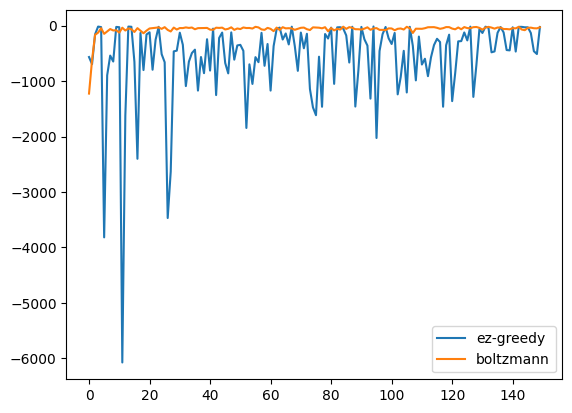

In [6]:
# Comparison of ez_greedy and boltzmann.

episodes = 150

# Agent's progression through each episode.
agent = Agent(env_3)
agent_1 = Agent(env_3)

# ez_greedy can lead to a local optimum with a lot of training(episodes).
# Higher learning rate leads to better results.
rewards_1 = agent.ez_q(episodes, decay_rate=0.0001, scale=2.5)
rewards_2 = agent_1.boltzmann_q(episodes, stats=True)

plt.plot(range(episodes), rewards_1, label='ez-greedy')
plt.plot(range(episodes), rewards_2, label='boltzmann')
plt.legend()
plt.show()

In [7]:
agent.use_policy(env=env_2, max_no_steps=20) # ez_greedy

-119

In [8]:
agent_1.use_policy(env=env_2, max_no_steps=20) # boltzmann

-16

In [10]:
agent.policy

array([1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [11]:
agent_1.policy

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])